## Pretraining on unlabeled Data 

### Evaluating generative text models

#### Using GPT to generate text

In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",
    "pandas",
    "matplotlib",
    "tiktoken",
    "Torch",
    "tensorflow"
]

for p in pkgs:
    print(f"{p}: {version(p)}")

numpy: 1.23.5
pandas: 2.2.3
matplotlib: 3.10.1
tiktoken: 0.9.0
Torch: 2.2.2
tensorflow: 2.16.2


In [2]:
from previous_chapters_ali import GPTModel
import torch


GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers , number of transformer blocks
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}


In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # opposite of model.train()

In [4]:
import tiktoken as tk
from previous_chapters_ali import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

In [5]:
start_context = "Every effort moves you"
tokenizer = tk.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)
token_ids

tensor([[6109, 3626, 6100,  345]])

In [6]:
def token_ids_to_text(token_ids, tokenizer):
    return tokenizer.decode(token_ids.squeeze(0).tolist())

In [7]:
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you'

In [8]:
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(start_context, tokenizer),
max_new_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [9]:
token_ids.squeeze(0).shape # 4 + 10 = 14

torch.Size([14])

#### Calculating the text generation loss: cross entropy and perplexity 

In [10]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                        [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

# there is no relationship between the two sentences in the inputs tensor


In [11]:
# generate the logits 

with torch.no_grad():
    logits = model(inputs)

In [12]:
logits.shape # (2, 3, 50257)

torch.Size([2, 3, 50257])

In [13]:
probas = torch.softmax(logits, dim=-1)
probas.shape # (2, 3, 50257)

torch.Size([2, 3, 50257])

In [14]:
probas[0,2,:].argmax()

tensor(42826)

In [15]:
probas[0,2,42826]

tensor(0.0002)

In [16]:
probas

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

In [17]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [18]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [19]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

# proba of the target id in our not trained model


Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [20]:
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [21]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2))) # the smaller the proba the higher the negative log proba is 
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [22]:
(-1)*torch.mean(log_probas) # cross entropy loss we need to minimize this value make it as close to 0 as possible ( in fac the log of a proba close to 1 is close to 0 that what we want)

tensor(10.7940)

In [23]:
logits.shape

torch.Size([2, 3, 50257])

In [24]:
logits_flat = logits.flatten(0,1)
logits_flat.shape

torch.Size([6, 50257])

In [25]:
targets_flat = targets.flatten()
targets_flat.shape

torch.Size([6])

In [26]:
# Faster way to compute it 
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.7940)

In [27]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [28]:
perplexity = torch.exp(loss)
print(perplexity)


tensor(48725.8203)


In the given example, this would translate to the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token.

 Perplexity measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.

#### Calculating the training and validation set losses


In [29]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [30]:
text_data[:1000]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [31]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [32]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [33]:
from previous_chapters_ali import create_dataloader_v1

In [34]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
    )

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
    )

In [35]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [36]:
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)


Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [37]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() # numel() returns the number of elements in the tensor (batch_size * context_length) example 2 * 256 = 512

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [38]:
torch.cuda.is_available()
#mps = torch.backends.mps.is_available() # mps for macOS

False

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cuda is a language for parallel computing on NVIDIA GPUs

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device) # transfering data to certain device (GPU or CPU) memory and model have to be on the same device
    logits = model(input_batch) # the model sit on the cpu but if computer support GPU it will be on the GPU if cuda is available
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [41]:
len(train_loader)

9

In [42]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
        
    return total_loss / num_batches

In [43]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader( train_loader, model, device)
    val_loss = calc_loss_loader( val_loader, model, device)

print("Train loss:", train_loss)
print("Validation loss:", val_loss)

Train loss: 10.987583584255642
Validation loss: 10.98110580444336


In [44]:
# perplexity 
torch.exp(torch.tensor([10.987])) # how ensure the model is about that many words 

tensor([59100.8438])

In [45]:
tokenizer.n_vocab

50257

### Training the LLM

In [46]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # to reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # compute the loss gradients
            optimizer.step() # update model weights using loss gradients (stochastic gradient descent for example)
            tokens_seen += input_batch.numel() 
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # print a sample text after each epoch to keep track of the model's progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [47]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) # AdamW is a variant of Adam optimizer with weight decay or we can use SGD optimizer

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

In [48]:
print("Train losses:", train_losses)

Train losses: [9.781001853942872, 8.110534191131592, 6.660930633544922, 5.96102294921875, 5.7261350631713865, 5.201075077056885, 4.417182779312133, 4.068654775619507, 3.732058525085449, 2.8500417709350585, 2.4273252725601195, 2.1043038845062254, 1.8819355010986327, 1.3204445838928223, 0.9851559638977051, 0.716504180431366, 0.5412569999694824, 0.39095393419265745]


In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

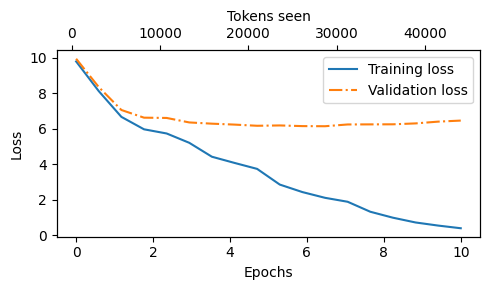

In [51]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Decoding strategies to control randomness

In [52]:
model.to("cpu")
model.eval();

In [53]:
tokenizer = tk.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
    )

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


#### temperature scaling

In [54]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [55]:
#model(x) produced by the model 
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
    )

In [56]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item() #item of the largest value in the tensor
print(inverse_vocab[next_token_id])

forward


In [57]:
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [58]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item() # print proportionally to the proba the words here 57% the 3rd word and 35 the 7th
print(inverse_vocab[next_token_id])

forward


In [59]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [60]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

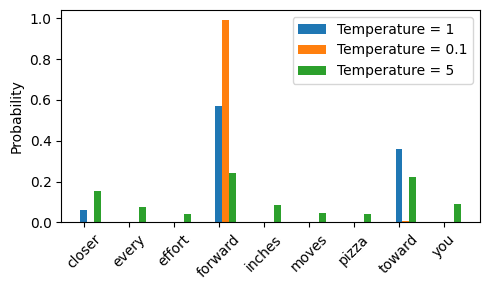

In [61]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
    bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

#### Top k sampling 

In [62]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [63]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [64]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [65]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### Modifying the text generation function


In [66]:
tokenizer.n_vocab

50257

In [67]:
tokenizer.decode([50256]) # this is the end opfn sequence token

'<|endoftext|>'

In [68]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # for all batches, only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k) # _ is the index of the top k logits
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [69]:
torch.manual_seed(123)
token_ids = generate(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=15,
context_size=GPT_CONFIG_124M["context_length"],
top_k=25,
temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


### Loading and saving model weights in PyTorch

In [70]:
torch.save(model.state_dict(),"model.pth") # this cointain the model weights

In [71]:
torch.save({
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
},
"model_and_optimizer.pth"
)

In [72]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

### Loading pretrained weights from OpenAI

##### check with oscar or yousra

In [73]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.16.2
tqdm version: 4.67.1


In [74]:
#from llms_from_scratch.ch05 import download_and_load_gpt2
pkgs = ["torch"]
for p in pkgs:
    print(f"{p} version: {version(p)}")

torch version: 2.2.2


In [75]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [76]:
file_name = "gpt2-small-124M.pth"

In [77]:
import os
import urllib.request

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

In [78]:
import torch
from previous_chapters_ali import GPTModel

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);

In [79]:
torch.manual_seed(123)

tokenizer = tk.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not


In [82]:

model_name = "gpt2-small (124M)" 
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

In [83]:
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(NEW_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


